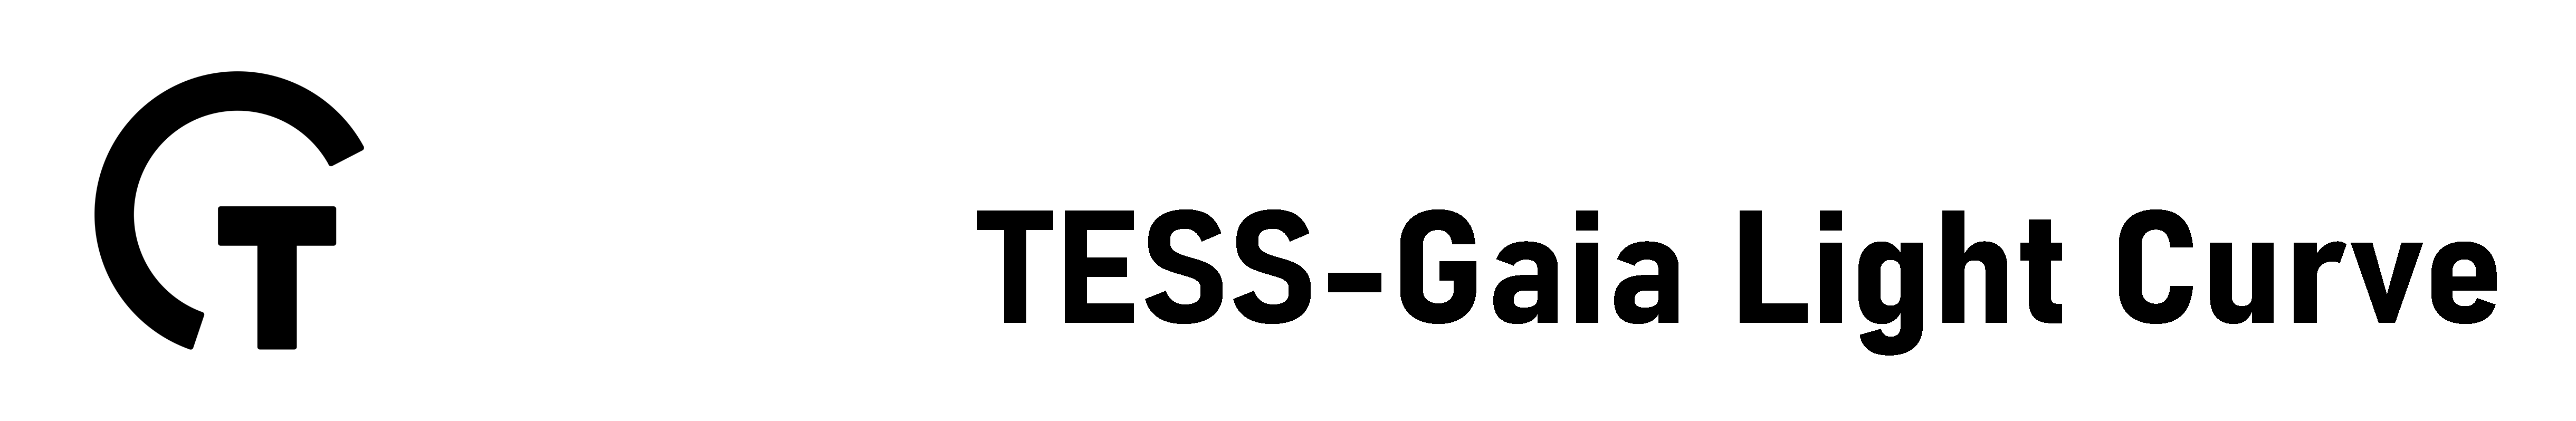

TESS-Gaia Light Curve (TGLC) is a dataset of TESS full-frame image light curves publicly available via the MAST portal. It is fitted with effective PSF and decontaminated with Gaia DR2 and achieved percent-level photometric precision down to 16th magnitude! It unlocks astrophysics to a vast number of dim stars below 12th magnitude. Here we introduce the basic data structure of our light curves and show simple analysis. 

# 1. Obtain Light curves

There are two ways to get the light curves: 
### 1. Download from the MAST portal (to be continued ...)

### 2. Fit with the package `tglc`. (SKIP THIS IF YOU USE MAST)

First install `tglc` with pip: `pip install tglc`. https://pypi.org/project/tglc/ Require python version 3.8.0 or newer.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tglc.quick_lc import tglc_lc

target = 'TIC 269826902'     # Target ID ('TOI 519') or coordinates ('ra dec')
local_directory = f'{target}/'    # directory to save all files
os.makedirs(local_directory, exist_ok=True)
tglc_lc(target=target, 
        local_directory=local_directory, 
        size=50, # FFI cutsize. Recommand 50 or larger for best performance. Cannot exceed 99. 
        save_aper=True, # whether to save 5*5 timeseries of the decontaminated images in fits file primary HDU
        limit_mag=15, # the TESS magnitude limit of stars to output
        get_all_lc=False, # whether to return all lcs in the region. If False, return the nearest star to the target coordinate
        first_sector_only=True, # whether to return only lcs from the sector this target was first observed. 
                                # If False, return all sectors of the target, but too many sectors could be slow.
        sector=True # If first_sector_only=True, sector must be True
                    # If first_sector_only=False, specify a sector number to return
       )

Target Gaia: Gaia DR2 140231197611108480
INFO: Query finished. [astroquery.utils.tap.core]
Found 1723 Gaia DR2 objects.
Found 1549 TIC objects.
  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0018-1-3     18      1   3


Fitting ePSF:   0%|          | 0/1002 [00:00<?, ?it/s]

Already in sector 18.


Fitting lc: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


This could take awhile to download depending on the cutsize and sector numbers. Once finished, you get the light curves you asked and can check the FFI cut and the effective PSF shape.

sector = 18


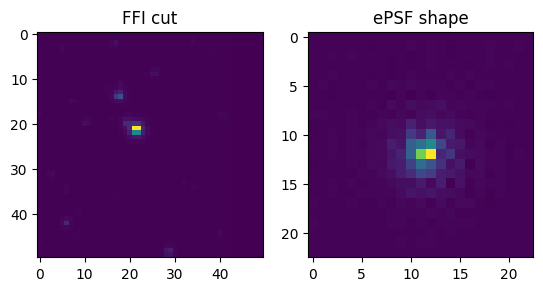

In [4]:
import pickle
with open(f'{local_directory}source/source_TIC 269826902_earliest_sector.pkl', 'rb') as input_:
    source = pickle.load(input_)
    print(f'sector = {source.sector}')
epsf = np.load(f'{local_directory}epsf/epsf_TIC 269826902_sector_18.npy')

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(source.flux[0])
ax1.set_title('FFI cut')
ax2.imshow(epsf[0,:23**2].reshape(23,23))
ax2.set_title('ePSF shape')
plt.show()
# print(source.gaia[:5]) # all the gaia stars 
# print(source.tic[:5]) # TIC ID to Gaia DR2 conversion

# 2. Data structure

In [2]:
from astropy.io import fits
hdul_s007 = fits.open('hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0007-cam2-ccd3_tess_v1_llc.fits')
hdul_s007.info()

Filename: hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0007-cam2-ccd3_tess_v1_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (5, 5, 1086)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   1086R x 9C   [D, E, E, E, E, E, J, I, I]   


The naming of tglc light curves follows the structure:
hlsp_tglc_tess_ffi_gaiaid-{Gaia DR2 ID}-s{sector}-cam{camera No.}-ccd{CCD No.}_tess_v1_llc.fits

Each light curve fits file has two HDUs: the Primary HDU is a 5\*5 pixels cut around the star (will be empty if you downloaded from MAST); the Second HDU contains the light curves. 

# 3. Exoplanet example
Let's look at a faint star (14.5 TESS mag) hosting an exoplanet. Below are the raw light curves of TOI-519.

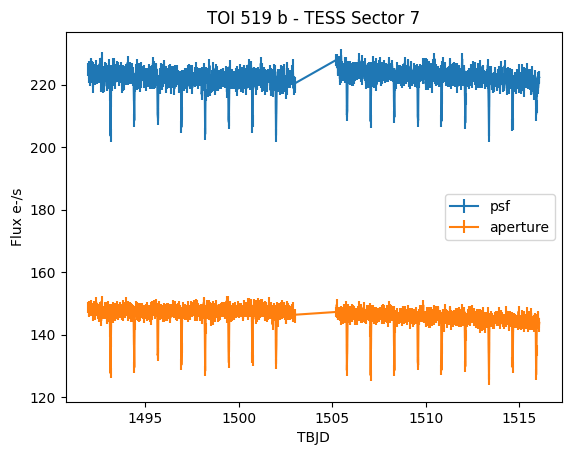

In [3]:
q_07 = list(hdul_s007[1].data['TESS_flags'] == 0) and list(hdul_s007[1].data['TGLC_flags'] == 0)
# filter out bad datapoints from both TESS FFI flags and TGLC flags

time_07 = hdul_s007[1].data['time'][q_07]
psf_flux_07 = hdul_s007[1].data['psf_flux'][q_07] # raw psf flux
psf_flux_err_07 = hdul_s007[1].header['PSF_ERR'] # raw psf flux error
aper_flux_07 = hdul_s007[1].data['aperture_flux'][q_07] # raw aper flux
aper_flux_err_07 = hdul_s007[1].header['APER_ERR'] # raw aper flux error
plt.errorbar(time_07, psf_flux_07, psf_flux_err_07, marker = '', label = 'psf')
plt.errorbar(time_07, aper_flux_07, aper_flux_err_07, marker = '', label = 'aperture')
plt.title('TOI 519 b - TESS Sector 7')
plt.xlabel('TBJD')
plt.ylabel('Flux e-/s')
plt.legend()
plt.show()

Note that the two light curves have different median flux levels. This is because the raw aperture flux only sums a 3\*3 pixel region around the star, which is not 100\% of the flux from the star. We account for this as well as the low frequency trend in the calibrated light curves. 

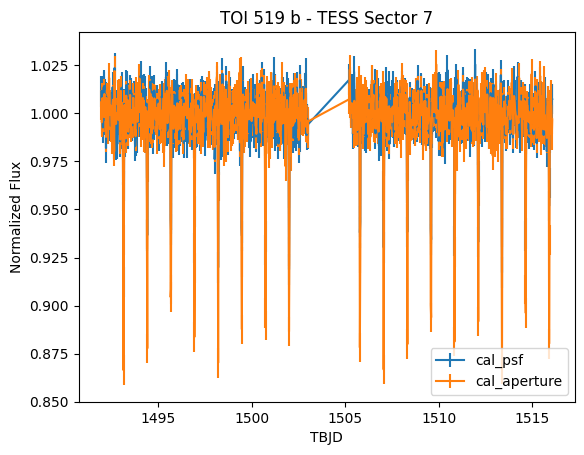

In [4]:
cal_psf_flux_07 = hdul_s007[1].data['cal_psf_flux'][q_07] # raw psf flux
cal_psf_flux_err_07 = hdul_s007[1].header['CPSF_ERR'] # raw psf flux error
cal_aper_flux_07 = hdul_s007[1].data['cal_aper_flux'][q_07] # raw aper flux
cal_aper_flux_err_07 = hdul_s007[1].header['CAPE_ERR'] # raw aper flux error
plt.errorbar(time_07, cal_psf_flux_07, cal_psf_flux_err_07, marker = '', label = 'cal_psf')
plt.errorbar(time_07, cal_aper_flux_07, cal_aper_flux_err_07, marker = '', label = 'cal_aperture')
plt.title('TOI 519 b - TESS Sector 7')
plt.xlabel('TBJD')
plt.ylabel('Normalized Flux')
plt.legend()
plt.show()

We can also crossmatch different sectors of the same star. TOI-519 has been observed by TESS for three times until today. We will bin all sectors to 30-min for fair comparison. 

In [5]:
hdul_s008 = fits.open('hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0008-cam2-ccd4_tess_v1_llc.fits')
q_08 = list(hdul_s008[1].data['TESS_flags'] == 0) and list(hdul_s008[1].data['TGLC_flags'] == 0)
time_08 = hdul_s008[1].data['time'][q_08]
cal_psf_flux_08 = hdul_s008[1].data['cal_psf_flux'][q_08] # raw psf flux
cal_psf_flux_err_08 = hdul_s008[1].header['CPSF_ERR'] # raw psf flux error

hdul_s034 = fits.open('hlsp_tglc_tess_ffi_gaiaid-5707485527450614656-s0034-cam2-ccd3_tess_v1_llc.fits')
q_34 = list(hdul_s034[1].data['TESS_flags'] == 0) and list(hdul_s034[1].data['TGLC_flags'] == 0)
time_34 = hdul_s034[1].data['time'][q_34]
time_34 = np.mean(time_34[:len(time_34) // 3 * 3].reshape(-1, 3), axis=1)
cal_psf_flux_34 = hdul_s034[1].data['cal_psf_flux'][q_34] # raw psf flux
cal_psf_flux_34 = np.mean(cal_psf_flux_34[:len(cal_psf_flux_34) // 3 * 3].reshape(-1, 3), axis=1)
cal_psf_flux_err_34 = hdul_s034[1].header['CPSF_ERR'] # raw psf flux error

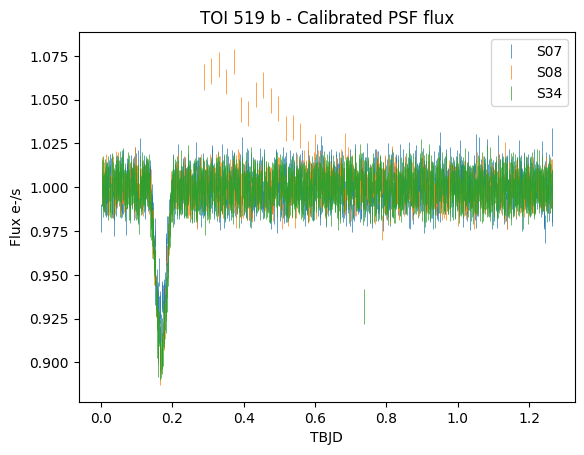

In [6]:
period = 1.2652328 # this work
plt.errorbar(time_07 % period, cal_psf_flux_07, cal_psf_flux_err_07, marker = '', lw=0.5, ls = '', label = 'S07')
plt.errorbar(time_08 % period, cal_psf_flux_08, cal_psf_flux_err_08, marker = '', lw=0.5, ls = '', label = 'S08')
plt.errorbar(time_34 % period, cal_psf_flux_34, cal_psf_flux_err_34, marker = '', lw=0.5, ls = '', label = 'S34')
plt.title('TOI 519 b - Calibrated PSF flux')
plt.xlabel('TBJD')
plt.ylabel('Flux e-/s')
plt.legend()
plt.show()

The two flags take out the majority of bad datapoints, although several outliers remain. We can see a consistant transit depth among three sectors, an indication of the robustness of tglc.